Using the [tutorial from Jason Chong](https://github.com/chongjason914/kaggle-titanic/blob/main/titanic-tutorial.ipynb) to try to create my own model.

In [1]:
#These are directly taken from the tutorial for ease

# Data wrangling
import pandas as pd
import numpy as np
from collections import Counter

# Data visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning models
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

# Model evaluation
from sklearn.model_selection import cross_val_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

In [2]:
df_train = pd.read_csv('data_sets/train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_test = pd.read_csv('data_sets/test.csv')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
orig_test_df = df_test.copy()  # copying original test set for later usage

Based on the original EDA, we already have the following hypotheses and what we should include in our features to try to make a more accurate model. 

1. Women are more likely to survive
2. First class are more likely to survive
3. Those embarking in France have the most 1st class passengers and are more likely to survive. 
4. Men getting on in Cobh had a terrible chance, women getting on in Cherbourg have a very high chance.

Based on the tutorial there are some new interesting features that have been left out of previous models that we could explore. For example the previous models dropped age and name. However it's possible to extract title from the name, and also deduce some missing values for age in order to fill out/create some new features. The itle example is from the tutorial. 

So new features I want to create:
1. Sex * Embarkation point. This gives the highest disparity between survival rates, with men embarking in Cobh at 7% chance of survival, and women embarking in France with an 87% survival rate. I might take what Jason did with title and embarkation point, and adapt this for my own EDA. But it would mean I somehow have to make embarkation point numerical.
2. Siblings - this was touched on in the EDA file, where it showed that those with one sibling having a higher chance of surviving (53%) than those that had any other number of siblings - this chance was also higher than the general survival rate (38%). The chance of surviving if travelling alone was lower (more likely to be ship workers/single men/third class?) than the regular survival rate, although not by much (34%). 3 siblings brings your rate down to 25% and it only gets worse from there (third class large families maybe.) 


I will start by creating my new columns, then encoding them, then trying a model. 
To start, I need to combine the training and test dataset so that they both can have the new columns, then I can split them out at the end again. 

2. Siblings/Parents/Family size

In [5]:
combined = pd.concat([df_train, df_test], axis = 0).reset_index(drop = True)
combined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
combined.isnull().sum().sort_values(ascending = False)

Cabin          1014
Survived        418
Age             263
Embarked          2
Fare              1
PassengerId       0
Pclass            0
Name              0
Sex               0
SibSp             0
Parch             0
Ticket            0
dtype: int64

In [7]:
combined = combined.drop(['Name', 'Cabin', 'Age', 'Name', 'Ticket'], axis = 1)
combined.head(10)

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,1,0.0,3,male,1,0,7.2500,S
1,2,1.0,1,female,1,0,71.2833,C
2,3,1.0,3,female,0,0,7.9250,S
3,4,1.0,1,female,1,0,53.1000,S
4,5,0.0,3,male,0,0,8.0500,S
5,6,0.0,3,male,0,0,8.4583,Q
6,7,0.0,1,male,0,0,51.8625,S
7,8,0.0,3,male,3,1,21.0750,S
8,9,1.0,3,female,0,2,11.1333,S
9,10,1.0,2,female,1,0,30.0708,C


In [8]:
combined['FamilySize'] = combined['SibSp'] + combined['Parch'] + 1 #1 being the person of the row
combined[['SibSp', 'Parch', 'FamilySize']].head(10)

,SibSp,Parch,FamilySize
0,1,0,2
1,1,0,2
2,0,0,1
3,1,0,2
4,0,0,1
5,0,0,1
6,0,0,1
7,3,1,5
8,0,2,3
9,1,0,2


In [9]:
combined[['FamilySize', 'Survived']].groupby('FamilySize', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


This column confirms what our EDA showed -  3 parch and one sibling are the factors that offer the highest survival rate. 

Ok Let's encode the other columns and see what data we have. 

In [10]:
combined = pd.get_dummies(combined, columns = ['Sex'])
combined = pd.get_dummies(combined, columns = ['Embarked'], prefix = 'Em')
combined.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Em_C,Em_Q,Em_S
0,1,0.0,3,1,0,7.2500,2,0,1,0,0,1
1,2,1.0,1,1,0,71.2833,2,1,0,1,0,0
2,3,1.0,3,0,0,7.9250,1,1,0,0,0,1
3,4,1.0,1,1,0,53.1000,2,1,0,0,0,1
4,5,0.0,3,0,0,8.0500,1,0,1,0,0,1


Ok I forgot that we have fare there. I didn't cover that in the EDA really, but will have a quick look now as maybe it's worth it. 

<Axes: >

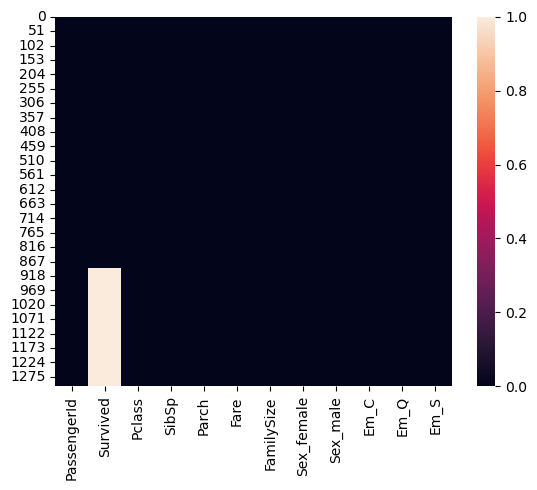

In [11]:
sns.heatmap(combined.isnull())

In [12]:
combined['Fare'] = combined['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

In [13]:
#ok didn't realise there were no nulls in fare- lets defo give it a go then. As it's continuous I will bucket it. 
#this and the following cell block are directly lifted from cell 83 and 84 by Chong
combined['Fare'].fillna(combined['Fare'].median(), inplace=True)
combined['FareBand'] = pd.cut(combined['Fare'], 4)
combined[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by = 'FareBand')

,FareBand,Survived
0,"(-0.00624, 1.56]",0.062500
1,"(1.56, 3.119]",0.288719
2,"(3.119, 4.679]",0.504983
3,"(4.679, 6.239]",0.745098


In [14]:
combined.loc[combined['Fare'] <= 1.56, 'Fare'] = 0
combined.loc[(combined['Fare'] > 1.56) & (combined['Fare'] <= 3.119), 'Fare'] = 1
combined.loc[(combined['Fare'] > 3.119) & (combined['Fare'] <= 4.679), 'Fare'] = 2
combined.loc[combined['Fare'] > 4.679, 'Fare'] = 3

In [15]:
combined['Fare'] = combined['Fare'].astype('int')

In [16]:
combined.head(10)

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Em_C,Em_Q,Em_S,FareBand
0,1,0.0,3,1,0,1,2,0,1,0,0,1,"(1.56, 3.119]"
1,2,1.0,1,1,0,2,2,1,0,1,0,0,"(3.119, 4.679]"
2,3,1.0,3,0,0,1,1,1,0,0,0,1,"(1.56, 3.119]"
3,4,1.0,1,1,0,2,2,1,0,0,0,1,"(3.119, 4.679]"
4,5,0.0,3,0,0,1,1,0,1,0,0,1,"(1.56, 3.119]"
5,6,0.0,3,0,0,1,1,0,1,0,1,0,"(1.56, 3.119]"
6,7,0.0,1,0,0,2,1,0,1,0,0,1,"(3.119, 4.679]"
7,8,0.0,3,3,1,1,5,0,1,0,0,1,"(1.56, 3.119]"
8,9,1.0,3,0,2,1,3,1,0,0,0,1,"(1.56, 3.119]"
9,10,1.0,2,1,0,2,2,1,0,1,0,0,"(3.119, 4.679]"


In [17]:
combined[['Fare', 'Survived']].groupby(['Fare'], as_index=False).mean().sort_values(by = 'Fare')

,Fare,Survived
0,0,0.062500
1,1,0.288719
2,2,0.504983
3,3,0.745098


In [18]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1309 non-null   int64   
 1   Survived     891 non-null    float64 
 2   Pclass       1309 non-null   int64   
 3   SibSp        1309 non-null   int64   
 4   Parch        1309 non-null   int64   
 5   Fare         1309 non-null   int32   
 6   FamilySize   1309 non-null   int64   
 7   Sex_female   1309 non-null   uint8   
 8   Sex_male     1309 non-null   uint8   
 9   Em_C         1309 non-null   uint8   
 10  Em_Q         1309 non-null   uint8   
 11  Em_S         1309 non-null   uint8   
 12  FareBand     1309 non-null   category
dtypes: category(1), float64(1), int32(1), int64(5), uint8(5)
memory usage: 74.5 KB


In [19]:
fare_survival_rate = combined[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand')

for index, row in fare_survival_rate.iterrows():
    fare_band = row['FareBand']
    fares_in_band = combined.loc[combined['FareBand'] == fare_band, 'Fare']
    print(f"FareBand: {fare_band}")
    print(f"Number of fares: {len(fares_in_band)}")
    print(f"Fare distribution:\n{fares_in_band.describe()}\n")

FareBand: (-0.00624, 1.56]
Number of fares: 20
Fare distribution:
count    20.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: Fare, dtype: float64

FareBand: (1.56, 3.119]
Number of fares: 777
Fare distribution:
count    777.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: Fare, dtype: float64

FareBand: (3.119, 4.679]
Number of fares: 431
Fare distribution:
count    431.0
mean       2.0
std        0.0
min        2.0
25%        2.0
50%        2.0
75%        2.0
max        2.0
Name: Fare, dtype: float64

FareBand: (4.679, 6.239]
Number of fares: 81
Fare distribution:
count    81.0
mean      3.0
std       0.0
min       3.0
25%       3.0
50%       3.0
75%       3.0
max       3.0
Name: Fare, dtype: float64



Text(0.5, 1.0, 'Passenger Fare Distribution After Log Transformation')

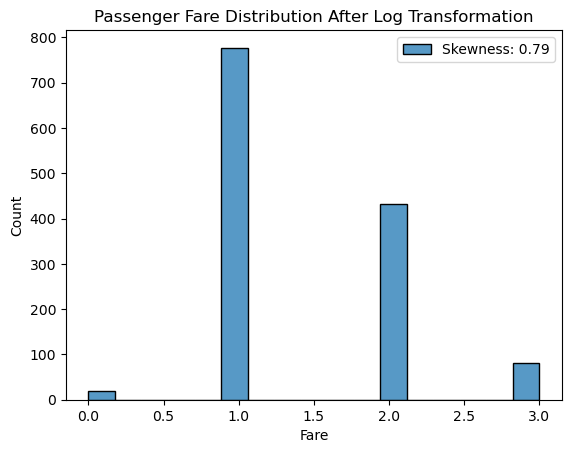

In [20]:
sns.histplot(combined['Fare'], label = 'Skewness: %.2f'%(combined['Fare'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Fare Distribution After Log Transformation')

Ok the skew is actually way too much, to the point that the banding is pointless. Will copy the skew fix from Chong and throw it a few cells above all this. Done it and not sure the cuts are really in the right place, but whatever, it will have to do! 

In [21]:
combined.head(20)

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Em_C,Em_Q,Em_S,FareBand
0,1,0.0,3,1,0,1,2,0,1,0,0,1,"(1.56, 3.119]"
1,2,1.0,1,1,0,2,2,1,0,1,0,0,"(3.119, 4.679]"
2,3,1.0,3,0,0,1,1,1,0,0,0,1,"(1.56, 3.119]"
3,4,1.0,1,1,0,2,2,1,0,0,0,1,"(3.119, 4.679]"
4,5,0.0,3,0,0,1,1,0,1,0,0,1,"(1.56, 3.119]"
5,6,0.0,3,0,0,1,1,0,1,0,1,0,"(1.56, 3.119]"
6,7,0.0,1,0,0,2,1,0,1,0,0,1,"(3.119, 4.679]"
7,8,0.0,3,3,1,1,5,0,1,0,0,1,"(1.56, 3.119]"
8,9,1.0,3,0,2,1,3,1,0,0,0,1,"(1.56, 3.119]"
9,10,1.0,2,1,0,2,2,1,0,1,0,0,"(3.119, 4.679]"


Ok next steps: 
- Remove FareBand
- Make survived an integer
- Split the dataset again back to test and train instead of combined (think I have to do this first, as survived has nulls so can't convert it yet)

In [22]:
combined = combined.drop('FareBand', axis = 1)

In [23]:
train = combined[:len(df_train)]
test = combined[len(df_train):]

In [24]:
train.head(5)

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Em_C,Em_Q,Em_S
0,1,0.0,3,1,0,1,2,0,1,0,0,1
1,2,1.0,1,1,0,2,2,1,0,1,0,0
2,3,1.0,3,0,0,1,1,1,0,0,0,1
3,4,1.0,1,1,0,2,2,1,0,0,0,1
4,5,0.0,3,0,0,1,1,0,1,0,0,1


In [25]:
train = train.drop(['PassengerId'], axis = 1)

In [26]:
train.head(5)

,Survived,Pclass,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Em_C,Em_Q,Em_S
0,0.0,3,1,0,1,2,0,1,0,0,1
1,1.0,1,1,0,2,2,1,0,1,0,0
2,1.0,3,0,0,1,1,1,0,0,0,1
3,1.0,1,1,0,2,2,1,0,0,0,1
4,0.0,3,0,0,1,1,0,1,0,0,1


In [27]:
train['Survived'] = train['Survived'].astype('int')

In [36]:
train.head()

,Survived,Pclass,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Em_C,Em_Q,Em_S
0,0,3,1,0,1,2,0,1,0,0,1
1,1,1,1,0,2,2,1,0,1,0,0
2,1,3,0,0,1,1,1,0,0,0,1
3,1,1,1,0,2,2,1,0,0,0,1
4,0,3,0,0,1,1,0,1,0,0,1


Ok now I think it's ready to get learning. 

# Split into X and y

In [45]:
print(train.shape)
print(test.shape)

(891, 11)
(418, 11)


In [46]:
train.head(5)

,Survived,Pclass,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Em_C,Em_Q,Em_S
0,0,3,1,0,1,2,0,1,0,0,1
1,1,1,1,0,2,2,1,0,1,0,0
2,1,3,0,0,1,1,1,0,0,0,1
3,1,1,1,0,2,2,1,0,0,0,1
4,0,3,0,0,1,1,0,1,0,0,1


In [47]:
test.head(5)

,PassengerId,Pclass,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Em_C,Em_Q,Em_S
891,892,3,0,0,1,1,0,1,0,1,0
892,893,3,1,0,1,2,1,0,0,0,1
893,894,2,0,0,1,1,0,1,0,1,0
894,895,3,0,0,1,1,0,1,0,0,1
895,896,3,1,1,1,3,1,0,0,0,1


In [48]:
test = test.drop('Survived', axis = 1)

KeyError: "['Survived'] not found in axis"

In [49]:
X_train = train.drop('Survived', axis = 1)
y_train = train['Survived']
X_test = test.drop('PassengerId', axis = 1).copy()
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (891, 10)
y_train shape:  (891,)
X_test shape:  (418, 10)


In [50]:
X_train.head()

,Pclass,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Em_C,Em_Q,Em_S
0,3,1,0,1,2,0,1,0,0,1
1,1,1,0,2,2,1,0,1,0,0
2,3,0,0,1,1,1,0,0,0,1
3,1,1,0,2,2,1,0,0,0,1
4,3,0,0,1,1,0,1,0,0,1


In [51]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int32

In [52]:
X_test.head()

,Pclass,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Em_C,Em_Q,Em_S
891,3,0,0,1,1,0,1,0,1,0
892,3,1,0,1,2,1,0,0,0,1
893,2,0,0,1,1,0,1,0,1,0
894,3,0,0,1,1,0,1,0,0,1
895,3,1,1,1,3,1,0,0,0,1


Now we have split it, we can run it through a few ML types to get some scores and see if we get any better performance from this. Chong does loads, but I will just do the ones I have heard of! 

## Logistic Regression

In [53]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log

78.79

## K-nearest Neighbours

In [57]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
acc_knn

82.38

## Decision Tree

In [59]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
acc_decision_tree

84.85

## Random Forest

In [60]:
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
acc_random_forest

84.85

In [63]:
classifiers = []
classifiers.append(LogisticRegression())
classifiers.append(KNeighborsClassifier(n_neighbors = 5))
classifiers.append(DecisionTreeClassifier())
classifiers.append(CatBoostClassifier())

len(classifiers)

4

In [65]:
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y_train, scoring = 'accuracy', cv = 10))

Learning rate set to 0.009371
0:	learn: 0.6864959	total: 149ms	remaining: 2m 29s
1:	learn: 0.6801351	total: 155ms	remaining: 1m 17s
2:	learn: 0.6749523	total: 159ms	remaining: 52.7s
3:	learn: 0.6695200	total: 163ms	remaining: 40.5s
4:	learn: 0.6638677	total: 167ms	remaining: 33.2s
5:	learn: 0.6582691	total: 170ms	remaining: 28.2s
6:	learn: 0.6531394	total: 174ms	remaining: 24.7s
7:	learn: 0.6475576	total: 178ms	remaining: 22.1s
8:	learn: 0.6429734	total: 182ms	remaining: 20s
9:	learn: 0.6381976	total: 185ms	remaining: 18.3s
10:	learn: 0.6334168	total: 187ms	remaining: 16.8s
11:	learn: 0.6280915	total: 189ms	remaining: 15.6s
12:	learn: 0.6226873	total: 191ms	remaining: 14.5s
13:	learn: 0.6174349	total: 194ms	remaining: 13.6s
14:	learn: 0.6143362	total: 196ms	remaining: 12.9s
15:	learn: 0.6104923	total: 199ms	remaining: 12.3s
16:	learn: 0.6065075	total: 203ms	remaining: 11.8s
17:	learn: 0.6018697	total: 207ms	remaining: 11.3s
18:	learn: 0.5974065	total: 210ms	remaining: 10.9s
19:	learn: 

208:	learn: 0.4025562	total: 930ms	remaining: 3.52s
209:	learn: 0.4024445	total: 932ms	remaining: 3.51s
210:	learn: 0.4023008	total: 936ms	remaining: 3.5s
211:	learn: 0.4022476	total: 940ms	remaining: 3.49s
212:	learn: 0.4021632	total: 944ms	remaining: 3.49s
213:	learn: 0.4019098	total: 949ms	remaining: 3.48s
214:	learn: 0.4017501	total: 952ms	remaining: 3.48s
215:	learn: 0.4015752	total: 956ms	remaining: 3.47s
216:	learn: 0.4014387	total: 958ms	remaining: 3.46s
217:	learn: 0.4012249	total: 961ms	remaining: 3.45s
218:	learn: 0.4010827	total: 963ms	remaining: 3.44s
219:	learn: 0.4008270	total: 978ms	remaining: 3.47s
220:	learn: 0.4006350	total: 984ms	remaining: 3.47s
221:	learn: 0.4003933	total: 989ms	remaining: 3.47s
222:	learn: 0.4001566	total: 993ms	remaining: 3.46s
223:	learn: 0.4001261	total: 997ms	remaining: 3.45s
224:	learn: 0.3999806	total: 1s	remaining: 3.45s
225:	learn: 0.3997919	total: 1s	remaining: 3.44s
226:	learn: 0.3996304	total: 1.01s	remaining: 3.44s
227:	learn: 0.39945

399:	learn: 0.3831517	total: 1.69s	remaining: 2.53s
400:	learn: 0.3831420	total: 1.7s	remaining: 2.53s
401:	learn: 0.3830978	total: 1.7s	remaining: 2.53s
402:	learn: 0.3830239	total: 1.7s	remaining: 2.52s
403:	learn: 0.3829535	total: 1.71s	remaining: 2.52s
404:	learn: 0.3829143	total: 1.71s	remaining: 2.52s
405:	learn: 0.3828589	total: 1.72s	remaining: 2.51s
406:	learn: 0.3828439	total: 1.72s	remaining: 2.5s
407:	learn: 0.3827886	total: 1.72s	remaining: 2.5s
408:	learn: 0.3827868	total: 1.72s	remaining: 2.49s
409:	learn: 0.3826857	total: 1.73s	remaining: 2.48s
410:	learn: 0.3825692	total: 1.73s	remaining: 2.48s
411:	learn: 0.3825030	total: 1.73s	remaining: 2.47s
412:	learn: 0.3824795	total: 1.74s	remaining: 2.47s
413:	learn: 0.3824513	total: 1.74s	remaining: 2.46s
414:	learn: 0.3824386	total: 1.74s	remaining: 2.46s
415:	learn: 0.3824226	total: 1.75s	remaining: 2.46s
416:	learn: 0.3823547	total: 1.75s	remaining: 2.45s
417:	learn: 0.3823416	total: 1.76s	remaining: 2.44s
418:	learn: 0.382

599:	learn: 0.3737986	total: 2.46s	remaining: 1.64s
600:	learn: 0.3737643	total: 2.47s	remaining: 1.64s
601:	learn: 0.3737022	total: 2.47s	remaining: 1.63s
602:	learn: 0.3736946	total: 2.47s	remaining: 1.63s
603:	learn: 0.3735995	total: 2.48s	remaining: 1.62s
604:	learn: 0.3735466	total: 2.48s	remaining: 1.62s
605:	learn: 0.3735143	total: 2.48s	remaining: 1.61s
606:	learn: 0.3735134	total: 2.48s	remaining: 1.61s
607:	learn: 0.3734928	total: 2.48s	remaining: 1.6s
608:	learn: 0.3734459	total: 2.49s	remaining: 1.6s
609:	learn: 0.3733711	total: 2.49s	remaining: 1.59s
610:	learn: 0.3733524	total: 2.5s	remaining: 1.59s
611:	learn: 0.3732744	total: 2.5s	remaining: 1.58s
612:	learn: 0.3732241	total: 2.5s	remaining: 1.58s
613:	learn: 0.3732034	total: 2.51s	remaining: 1.58s
614:	learn: 0.3731756	total: 2.51s	remaining: 1.57s
615:	learn: 0.3731600	total: 2.52s	remaining: 1.57s
616:	learn: 0.3731062	total: 2.52s	remaining: 1.56s
617:	learn: 0.3730876	total: 2.52s	remaining: 1.56s
618:	learn: 0.373

800:	learn: 0.3655524	total: 3.24s	remaining: 804ms
801:	learn: 0.3655431	total: 3.24s	remaining: 800ms
802:	learn: 0.3655054	total: 3.24s	remaining: 796ms
803:	learn: 0.3654948	total: 3.25s	remaining: 792ms
804:	learn: 0.3654603	total: 3.25s	remaining: 788ms
805:	learn: 0.3654598	total: 3.25s	remaining: 783ms
806:	learn: 0.3653860	total: 3.25s	remaining: 779ms
807:	learn: 0.3652989	total: 3.26s	remaining: 774ms
808:	learn: 0.3652026	total: 3.26s	remaining: 770ms
809:	learn: 0.3651354	total: 3.26s	remaining: 765ms
810:	learn: 0.3651104	total: 3.27s	remaining: 761ms
811:	learn: 0.3650980	total: 3.27s	remaining: 757ms
812:	learn: 0.3650466	total: 3.27s	remaining: 752ms
813:	learn: 0.3650283	total: 3.27s	remaining: 749ms
814:	learn: 0.3650013	total: 3.28s	remaining: 744ms
815:	learn: 0.3649964	total: 3.29s	remaining: 741ms
816:	learn: 0.3649676	total: 3.29s	remaining: 737ms
817:	learn: 0.3648831	total: 3.29s	remaining: 733ms
818:	learn: 0.3648022	total: 3.3s	remaining: 729ms
819:	learn: 0

Learning rate set to 0.009376
0:	learn: 0.6877280	total: 4.53ms	remaining: 4.53s
1:	learn: 0.6815086	total: 8.91ms	remaining: 4.44s
2:	learn: 0.6762149	total: 13ms	remaining: 4.31s
3:	learn: 0.6708888	total: 17.5ms	remaining: 4.35s
4:	learn: 0.6652457	total: 22.2ms	remaining: 4.42s
5:	learn: 0.6596550	total: 26.5ms	remaining: 4.39s
6:	learn: 0.6545947	total: 30.9ms	remaining: 4.38s
7:	learn: 0.6493404	total: 35.1ms	remaining: 4.36s
8:	learn: 0.6448253	total: 39.4ms	remaining: 4.34s
9:	learn: 0.6399988	total: 43.7ms	remaining: 4.33s
10:	learn: 0.6352093	total: 48ms	remaining: 4.32s
11:	learn: 0.6299578	total: 52.4ms	remaining: 4.31s
12:	learn: 0.6256996	total: 56.2ms	remaining: 4.27s
13:	learn: 0.6213646	total: 60.6ms	remaining: 4.27s
14:	learn: 0.6167905	total: 65ms	remaining: 4.27s
15:	learn: 0.6128924	total: 69.2ms	remaining: 4.25s
16:	learn: 0.6083951	total: 73.2ms	remaining: 4.23s
17:	learn: 0.6048454	total: 76.7ms	remaining: 4.18s
18:	learn: 0.6009287	total: 80.6ms	remaining: 4.16

168:	learn: 0.4137219	total: 561ms	remaining: 2.76s
169:	learn: 0.4133648	total: 564ms	remaining: 2.75s
170:	learn: 0.4131098	total: 566ms	remaining: 2.75s
171:	learn: 0.4127767	total: 568ms	remaining: 2.74s
172:	learn: 0.4125795	total: 570ms	remaining: 2.73s
173:	learn: 0.4122752	total: 572ms	remaining: 2.72s
174:	learn: 0.4121974	total: 574ms	remaining: 2.7s
175:	learn: 0.4121049	total: 575ms	remaining: 2.69s
176:	learn: 0.4119761	total: 577ms	remaining: 2.68s
177:	learn: 0.4117880	total: 579ms	remaining: 2.67s
178:	learn: 0.4117030	total: 581ms	remaining: 2.66s
179:	learn: 0.4115054	total: 583ms	remaining: 2.65s
180:	learn: 0.4114459	total: 584ms	remaining: 2.64s
181:	learn: 0.4112184	total: 587ms	remaining: 2.64s
182:	learn: 0.4111109	total: 588ms	remaining: 2.63s
183:	learn: 0.4108480	total: 590ms	remaining: 2.62s
184:	learn: 0.4105448	total: 594ms	remaining: 2.62s
185:	learn: 0.4104131	total: 597ms	remaining: 2.61s
186:	learn: 0.4102566	total: 601ms	remaining: 2.61s
187:	learn: 0

350:	learn: 0.3872412	total: 1.14s	remaining: 2.11s
351:	learn: 0.3871539	total: 1.15s	remaining: 2.11s
352:	learn: 0.3871482	total: 1.15s	remaining: 2.1s
353:	learn: 0.3870015	total: 1.15s	remaining: 2.1s
354:	learn: 0.3868588	total: 1.15s	remaining: 2.09s
355:	learn: 0.3867336	total: 1.15s	remaining: 2.09s
356:	learn: 0.3866987	total: 1.16s	remaining: 2.08s
357:	learn: 0.3865199	total: 1.16s	remaining: 2.08s
358:	learn: 0.3864881	total: 1.16s	remaining: 2.07s
359:	learn: 0.3863351	total: 1.16s	remaining: 2.07s
360:	learn: 0.3862378	total: 1.16s	remaining: 2.06s
361:	learn: 0.3861809	total: 1.17s	remaining: 2.06s
362:	learn: 0.3861714	total: 1.17s	remaining: 2.05s
363:	learn: 0.3860411	total: 1.17s	remaining: 2.04s
364:	learn: 0.3860126	total: 1.17s	remaining: 2.04s
365:	learn: 0.3859292	total: 1.19s	remaining: 2.05s
366:	learn: 0.3858310	total: 1.19s	remaining: 2.05s
367:	learn: 0.3857936	total: 1.19s	remaining: 2.05s
368:	learn: 0.3857329	total: 1.19s	remaining: 2.04s
369:	learn: 0.

523:	learn: 0.3760935	total: 1.73s	remaining: 1.57s
524:	learn: 0.3760930	total: 1.74s	remaining: 1.57s
525:	learn: 0.3759854	total: 1.74s	remaining: 1.57s
526:	learn: 0.3759791	total: 1.74s	remaining: 1.56s
527:	learn: 0.3759377	total: 1.75s	remaining: 1.56s
528:	learn: 0.3759076	total: 1.75s	remaining: 1.56s
529:	learn: 0.3758022	total: 1.75s	remaining: 1.56s
530:	learn: 0.3757550	total: 1.76s	remaining: 1.55s
531:	learn: 0.3756758	total: 1.76s	remaining: 1.55s
532:	learn: 0.3756387	total: 1.77s	remaining: 1.55s
533:	learn: 0.3755649	total: 1.77s	remaining: 1.54s
534:	learn: 0.3755280	total: 1.77s	remaining: 1.54s
535:	learn: 0.3754218	total: 1.78s	remaining: 1.54s
536:	learn: 0.3754108	total: 1.78s	remaining: 1.54s
537:	learn: 0.3753055	total: 1.79s	remaining: 1.53s
538:	learn: 0.3752984	total: 1.79s	remaining: 1.53s
539:	learn: 0.3752522	total: 1.79s	remaining: 1.53s
540:	learn: 0.3752099	total: 1.79s	remaining: 1.52s
541:	learn: 0.3751820	total: 1.8s	remaining: 1.52s
542:	learn: 0

700:	learn: 0.3677402	total: 2.31s	remaining: 984ms
701:	learn: 0.3676686	total: 2.31s	remaining: 980ms
702:	learn: 0.3676568	total: 2.31s	remaining: 976ms
703:	learn: 0.3675777	total: 2.31s	remaining: 972ms
704:	learn: 0.3675163	total: 2.31s	remaining: 968ms
705:	learn: 0.3674598	total: 2.31s	remaining: 964ms
706:	learn: 0.3674326	total: 2.32s	remaining: 960ms
707:	learn: 0.3674187	total: 2.32s	remaining: 957ms
708:	learn: 0.3673238	total: 2.32s	remaining: 953ms
709:	learn: 0.3673083	total: 2.32s	remaining: 949ms
710:	learn: 0.3672449	total: 2.32s	remaining: 945ms
711:	learn: 0.3672010	total: 2.33s	remaining: 941ms
712:	learn: 0.3671899	total: 2.33s	remaining: 937ms
713:	learn: 0.3671501	total: 2.33s	remaining: 933ms
714:	learn: 0.3670478	total: 2.33s	remaining: 929ms
715:	learn: 0.3670363	total: 2.33s	remaining: 925ms
716:	learn: 0.3670268	total: 2.33s	remaining: 922ms
717:	learn: 0.3669956	total: 2.34s	remaining: 918ms
718:	learn: 0.3669929	total: 2.34s	remaining: 914ms
719:	learn: 

906:	learn: 0.3595154	total: 2.69s	remaining: 276ms
907:	learn: 0.3594783	total: 2.69s	remaining: 273ms
908:	learn: 0.3594726	total: 2.69s	remaining: 269ms
909:	learn: 0.3594550	total: 2.69s	remaining: 266ms
910:	learn: 0.3594294	total: 2.7s	remaining: 263ms
911:	learn: 0.3594185	total: 2.7s	remaining: 260ms
912:	learn: 0.3593523	total: 2.7s	remaining: 257ms
913:	learn: 0.3592975	total: 2.7s	remaining: 254ms
914:	learn: 0.3592817	total: 2.7s	remaining: 251ms
915:	learn: 0.3592727	total: 2.71s	remaining: 248ms
916:	learn: 0.3592478	total: 2.71s	remaining: 245ms
917:	learn: 0.3592381	total: 2.71s	remaining: 242ms
918:	learn: 0.3591818	total: 2.71s	remaining: 239ms
919:	learn: 0.3591533	total: 2.71s	remaining: 236ms
920:	learn: 0.3590861	total: 2.71s	remaining: 233ms
921:	learn: 0.3590448	total: 2.72s	remaining: 230ms
922:	learn: 0.3590118	total: 2.72s	remaining: 227ms
923:	learn: 0.3589955	total: 2.72s	remaining: 224ms
924:	learn: 0.3589540	total: 2.72s	remaining: 221ms
925:	learn: 0.358

128:	learn: 0.4139298	total: 379ms	remaining: 2.56s
129:	learn: 0.4134838	total: 382ms	remaining: 2.56s
130:	learn: 0.4130331	total: 385ms	remaining: 2.55s
131:	learn: 0.4126518	total: 387ms	remaining: 2.54s
132:	learn: 0.4121075	total: 389ms	remaining: 2.53s
133:	learn: 0.4115920	total: 393ms	remaining: 2.54s
134:	learn: 0.4111966	total: 395ms	remaining: 2.53s
135:	learn: 0.4109338	total: 397ms	remaining: 2.52s
136:	learn: 0.4104351	total: 398ms	remaining: 2.51s
137:	learn: 0.4098319	total: 400ms	remaining: 2.5s
138:	learn: 0.4095010	total: 402ms	remaining: 2.49s
139:	learn: 0.4090143	total: 403ms	remaining: 2.48s
140:	learn: 0.4082718	total: 405ms	remaining: 2.47s
141:	learn: 0.4078554	total: 407ms	remaining: 2.46s
142:	learn: 0.4075807	total: 409ms	remaining: 2.45s
143:	learn: 0.4069836	total: 411ms	remaining: 2.44s
144:	learn: 0.4064948	total: 415ms	remaining: 2.45s
145:	learn: 0.4059871	total: 418ms	remaining: 2.45s
146:	learn: 0.4055228	total: 422ms	remaining: 2.45s
147:	learn: 0

337:	learn: 0.3709922	total: 1.16s	remaining: 2.27s
338:	learn: 0.3707722	total: 1.16s	remaining: 2.27s
339:	learn: 0.3706318	total: 1.17s	remaining: 2.26s
340:	learn: 0.3705517	total: 1.17s	remaining: 2.26s
341:	learn: 0.3704894	total: 1.17s	remaining: 2.25s
342:	learn: 0.3704307	total: 1.18s	remaining: 2.25s
343:	learn: 0.3702996	total: 1.18s	remaining: 2.25s
344:	learn: 0.3702625	total: 1.18s	remaining: 2.24s
345:	learn: 0.3701510	total: 1.18s	remaining: 2.23s
346:	learn: 0.3701276	total: 1.19s	remaining: 2.23s
347:	learn: 0.3700079	total: 1.19s	remaining: 2.23s
348:	learn: 0.3699170	total: 1.19s	remaining: 2.22s
349:	learn: 0.3698058	total: 1.19s	remaining: 2.21s
350:	learn: 0.3697637	total: 1.2s	remaining: 2.21s
351:	learn: 0.3696380	total: 1.2s	remaining: 2.21s
352:	learn: 0.3696029	total: 1.2s	remaining: 2.2s
353:	learn: 0.3696013	total: 1.21s	remaining: 2.2s
354:	learn: 0.3694986	total: 1.21s	remaining: 2.2s
355:	learn: 0.3694322	total: 1.21s	remaining: 2.19s
356:	learn: 0.3694

503:	learn: 0.3593358	total: 1.74s	remaining: 1.71s
504:	learn: 0.3592838	total: 1.74s	remaining: 1.71s
505:	learn: 0.3592276	total: 1.74s	remaining: 1.7s
506:	learn: 0.3591563	total: 1.75s	remaining: 1.7s
507:	learn: 0.3591405	total: 1.75s	remaining: 1.69s
508:	learn: 0.3591210	total: 1.75s	remaining: 1.69s
509:	learn: 0.3591137	total: 1.75s	remaining: 1.68s
510:	learn: 0.3589780	total: 1.75s	remaining: 1.68s
511:	learn: 0.3589351	total: 1.76s	remaining: 1.68s
512:	learn: 0.3589151	total: 1.76s	remaining: 1.67s
513:	learn: 0.3589138	total: 1.76s	remaining: 1.67s
514:	learn: 0.3588554	total: 1.77s	remaining: 1.66s
515:	learn: 0.3588388	total: 1.77s	remaining: 1.66s
516:	learn: 0.3587684	total: 1.77s	remaining: 1.66s
517:	learn: 0.3587677	total: 1.78s	remaining: 1.66s
518:	learn: 0.3586932	total: 1.78s	remaining: 1.65s
519:	learn: 0.3586547	total: 1.79s	remaining: 1.65s
520:	learn: 0.3586266	total: 1.79s	remaining: 1.65s
521:	learn: 0.3585743	total: 1.8s	remaining: 1.64s
522:	learn: 0.3

665:	learn: 0.3519924	total: 2.33s	remaining: 1.17s
666:	learn: 0.3519666	total: 2.33s	remaining: 1.17s
667:	learn: 0.3519188	total: 2.34s	remaining: 1.16s
668:	learn: 0.3518756	total: 2.34s	remaining: 1.16s
669:	learn: 0.3518258	total: 2.34s	remaining: 1.15s
670:	learn: 0.3518024	total: 2.35s	remaining: 1.15s
671:	learn: 0.3517329	total: 2.35s	remaining: 1.15s
672:	learn: 0.3517033	total: 2.35s	remaining: 1.14s
673:	learn: 0.3516798	total: 2.35s	remaining: 1.14s
674:	learn: 0.3516415	total: 2.36s	remaining: 1.13s
675:	learn: 0.3516180	total: 2.36s	remaining: 1.13s
676:	learn: 0.3515950	total: 2.36s	remaining: 1.13s
677:	learn: 0.3515215	total: 2.37s	remaining: 1.12s
678:	learn: 0.3514873	total: 2.37s	remaining: 1.12s
679:	learn: 0.3513687	total: 2.37s	remaining: 1.12s
680:	learn: 0.3512741	total: 2.38s	remaining: 1.11s
681:	learn: 0.3512541	total: 2.38s	remaining: 1.11s
682:	learn: 0.3511529	total: 2.39s	remaining: 1.11s
683:	learn: 0.3511474	total: 2.39s	remaining: 1.1s
684:	learn: 0

887:	learn: 0.3430431	total: 2.9s	remaining: 366ms
888:	learn: 0.3430346	total: 2.9s	remaining: 362ms
889:	learn: 0.3430298	total: 2.9s	remaining: 359ms
890:	learn: 0.3430196	total: 2.9s	remaining: 355ms
891:	learn: 0.3430037	total: 2.91s	remaining: 352ms
892:	learn: 0.3429992	total: 2.91s	remaining: 348ms
893:	learn: 0.3429820	total: 2.91s	remaining: 345ms
894:	learn: 0.3429400	total: 2.91s	remaining: 342ms
895:	learn: 0.3429301	total: 2.91s	remaining: 338ms
896:	learn: 0.3429012	total: 2.92s	remaining: 335ms
897:	learn: 0.3428314	total: 2.92s	remaining: 331ms
898:	learn: 0.3428283	total: 2.92s	remaining: 328ms
899:	learn: 0.3428219	total: 2.92s	remaining: 324ms
900:	learn: 0.3427819	total: 2.92s	remaining: 321ms
901:	learn: 0.3427565	total: 2.92s	remaining: 318ms
902:	learn: 0.3427448	total: 2.93s	remaining: 315ms
903:	learn: 0.3426922	total: 2.93s	remaining: 311ms
904:	learn: 0.3426500	total: 2.93s	remaining: 308ms
905:	learn: 0.3426266	total: 2.94s	remaining: 305ms
906:	learn: 0.34

46:	learn: 0.5213681	total: 100ms	remaining: 2.03s
47:	learn: 0.5194059	total: 105ms	remaining: 2.07s
48:	learn: 0.5172344	total: 109ms	remaining: 2.11s
49:	learn: 0.5153600	total: 113ms	remaining: 2.14s
50:	learn: 0.5136018	total: 116ms	remaining: 2.16s
51:	learn: 0.5115524	total: 120ms	remaining: 2.19s
52:	learn: 0.5097597	total: 123ms	remaining: 2.2s
53:	learn: 0.5079192	total: 126ms	remaining: 2.2s
54:	learn: 0.5061155	total: 128ms	remaining: 2.21s
55:	learn: 0.5044656	total: 131ms	remaining: 2.21s
56:	learn: 0.5024229	total: 134ms	remaining: 2.22s
57:	learn: 0.5009049	total: 136ms	remaining: 2.21s
58:	learn: 0.4990790	total: 139ms	remaining: 2.21s
59:	learn: 0.4976555	total: 142ms	remaining: 2.22s
60:	learn: 0.4955687	total: 145ms	remaining: 2.23s
61:	learn: 0.4940080	total: 149ms	remaining: 2.26s
62:	learn: 0.4921146	total: 153ms	remaining: 2.28s
63:	learn: 0.4903352	total: 157ms	remaining: 2.3s
64:	learn: 0.4887755	total: 161ms	remaining: 2.31s
65:	learn: 0.4873195	total: 164ms	

295:	learn: 0.3960768	total: 887ms	remaining: 2.11s
296:	learn: 0.3959890	total: 891ms	remaining: 2.11s
297:	learn: 0.3958927	total: 894ms	remaining: 2.1s
298:	learn: 0.3956874	total: 896ms	remaining: 2.1s
299:	learn: 0.3955344	total: 899ms	remaining: 2.1s
300:	learn: 0.3954976	total: 902ms	remaining: 2.09s
301:	learn: 0.3953118	total: 906ms	remaining: 2.09s
302:	learn: 0.3951431	total: 909ms	remaining: 2.09s
303:	learn: 0.3950729	total: 912ms	remaining: 2.09s
304:	learn: 0.3948893	total: 915ms	remaining: 2.08s
305:	learn: 0.3948584	total: 917ms	remaining: 2.08s
306:	learn: 0.3947785	total: 920ms	remaining: 2.08s
307:	learn: 0.3946293	total: 922ms	remaining: 2.07s
308:	learn: 0.3945184	total: 925ms	remaining: 2.07s
309:	learn: 0.3944550	total: 927ms	remaining: 2.06s
310:	learn: 0.3943827	total: 930ms	remaining: 2.06s
311:	learn: 0.3943315	total: 932ms	remaining: 2.05s
312:	learn: 0.3942280	total: 935ms	remaining: 2.05s
313:	learn: 0.3941039	total: 937ms	remaining: 2.05s
314:	learn: 0.3

455:	learn: 0.3846896	total: 1.47s	remaining: 1.75s
456:	learn: 0.3846623	total: 1.47s	remaining: 1.75s
457:	learn: 0.3846297	total: 1.48s	remaining: 1.75s
458:	learn: 0.3846037	total: 1.48s	remaining: 1.74s
459:	learn: 0.3845709	total: 1.48s	remaining: 1.74s
460:	learn: 0.3844806	total: 1.49s	remaining: 1.74s
461:	learn: 0.3844769	total: 1.49s	remaining: 1.73s
462:	learn: 0.3844260	total: 1.49s	remaining: 1.73s
463:	learn: 0.3843950	total: 1.49s	remaining: 1.73s
464:	learn: 0.3843752	total: 1.5s	remaining: 1.72s
465:	learn: 0.3843737	total: 1.5s	remaining: 1.72s
466:	learn: 0.3843320	total: 1.5s	remaining: 1.71s
467:	learn: 0.3843033	total: 1.51s	remaining: 1.71s
468:	learn: 0.3842102	total: 1.51s	remaining: 1.71s
469:	learn: 0.3840671	total: 1.51s	remaining: 1.71s
470:	learn: 0.3839059	total: 1.52s	remaining: 1.7s
471:	learn: 0.3838191	total: 1.52s	remaining: 1.7s
472:	learn: 0.3836893	total: 1.53s	remaining: 1.7s
473:	learn: 0.3836428	total: 1.53s	remaining: 1.7s
474:	learn: 0.38358

654:	learn: 0.3756274	total: 2.22s	remaining: 1.17s
655:	learn: 0.3755562	total: 2.22s	remaining: 1.17s
656:	learn: 0.3754943	total: 2.23s	remaining: 1.16s
657:	learn: 0.3754773	total: 2.23s	remaining: 1.16s
658:	learn: 0.3754726	total: 2.23s	remaining: 1.16s
659:	learn: 0.3754540	total: 2.24s	remaining: 1.15s
660:	learn: 0.3753765	total: 2.24s	remaining: 1.15s
661:	learn: 0.3753522	total: 2.24s	remaining: 1.14s
662:	learn: 0.3752937	total: 2.24s	remaining: 1.14s
663:	learn: 0.3752589	total: 2.25s	remaining: 1.14s
664:	learn: 0.3751641	total: 2.25s	remaining: 1.13s
665:	learn: 0.3751551	total: 2.25s	remaining: 1.13s
666:	learn: 0.3751438	total: 2.25s	remaining: 1.13s
667:	learn: 0.3751362	total: 2.26s	remaining: 1.12s
668:	learn: 0.3750758	total: 2.26s	remaining: 1.12s
669:	learn: 0.3750233	total: 2.26s	remaining: 1.11s
670:	learn: 0.3749947	total: 2.27s	remaining: 1.11s
671:	learn: 0.3749213	total: 2.27s	remaining: 1.11s
672:	learn: 0.3749044	total: 2.28s	remaining: 1.1s
673:	learn: 0

814:	learn: 0.3692096	total: 2.79s	remaining: 634ms
815:	learn: 0.3691945	total: 2.8s	remaining: 631ms
816:	learn: 0.3691276	total: 2.8s	remaining: 627ms
817:	learn: 0.3690768	total: 2.8s	remaining: 624ms
818:	learn: 0.3690318	total: 2.81s	remaining: 620ms
819:	learn: 0.3690138	total: 2.81s	remaining: 616ms
820:	learn: 0.3689597	total: 2.81s	remaining: 613ms
821:	learn: 0.3688931	total: 2.81s	remaining: 609ms
822:	learn: 0.3688194	total: 2.81s	remaining: 605ms
823:	learn: 0.3687995	total: 2.81s	remaining: 601ms
824:	learn: 0.3687950	total: 2.82s	remaining: 598ms
825:	learn: 0.3687673	total: 2.82s	remaining: 594ms
826:	learn: 0.3687397	total: 2.82s	remaining: 591ms
827:	learn: 0.3687310	total: 2.82s	remaining: 587ms
828:	learn: 0.3687131	total: 2.83s	remaining: 583ms
829:	learn: 0.3686688	total: 2.83s	remaining: 580ms
830:	learn: 0.3686194	total: 2.83s	remaining: 576ms
831:	learn: 0.3685461	total: 2.84s	remaining: 573ms
832:	learn: 0.3685027	total: 2.84s	remaining: 570ms
833:	learn: 0.3

Learning rate set to 0.009376
0:	learn: 0.6879345	total: 4.71ms	remaining: 4.7s
1:	learn: 0.6816830	total: 9.93ms	remaining: 4.96s
2:	learn: 0.6764720	total: 14.8ms	remaining: 4.9s
3:	learn: 0.6715409	total: 19.6ms	remaining: 4.89s
4:	learn: 0.6660882	total: 24.7ms	remaining: 4.91s
5:	learn: 0.6610249	total: 29.6ms	remaining: 4.91s
6:	learn: 0.6560573	total: 34.5ms	remaining: 4.9s
7:	learn: 0.6510008	total: 39.8ms	remaining: 4.94s
8:	learn: 0.6465597	total: 44.5ms	remaining: 4.9s
9:	learn: 0.6414133	total: 49.3ms	remaining: 4.88s
10:	learn: 0.6367935	total: 54ms	remaining: 4.86s
11:	learn: 0.6321612	total: 58.2ms	remaining: 4.79s
12:	learn: 0.6280554	total: 62.1ms	remaining: 4.71s
13:	learn: 0.6238991	total: 66.5ms	remaining: 4.68s
14:	learn: 0.6194985	total: 71.5ms	remaining: 4.69s
15:	learn: 0.6157064	total: 75.6ms	remaining: 4.65s
16:	learn: 0.6115791	total: 80.2ms	remaining: 4.63s
17:	learn: 0.6081349	total: 83.8ms	remaining: 4.57s
18:	learn: 0.6043303	total: 88.6ms	remaining: 4.58

184:	learn: 0.4155917	total: 740ms	remaining: 3.26s
185:	learn: 0.4154287	total: 745ms	remaining: 3.26s
186:	learn: 0.4153853	total: 748ms	remaining: 3.25s
187:	learn: 0.4153189	total: 751ms	remaining: 3.24s
188:	learn: 0.4151811	total: 753ms	remaining: 3.23s
189:	learn: 0.4150013	total: 756ms	remaining: 3.22s
190:	learn: 0.4147469	total: 758ms	remaining: 3.21s
191:	learn: 0.4144324	total: 761ms	remaining: 3.2s
192:	learn: 0.4141985	total: 763ms	remaining: 3.19s
193:	learn: 0.4140899	total: 766ms	remaining: 3.18s
194:	learn: 0.4138058	total: 768ms	remaining: 3.17s
195:	learn: 0.4137331	total: 770ms	remaining: 3.16s
196:	learn: 0.4133532	total: 773ms	remaining: 3.15s
197:	learn: 0.4131032	total: 777ms	remaining: 3.15s
198:	learn: 0.4128008	total: 781ms	remaining: 3.14s
199:	learn: 0.4125511	total: 784ms	remaining: 3.14s
200:	learn: 0.4123660	total: 789ms	remaining: 3.14s
201:	learn: 0.4120320	total: 793ms	remaining: 3.13s
202:	learn: 0.4118932	total: 797ms	remaining: 3.13s
203:	learn: 0

389:	learn: 0.3929770	total: 1.53s	remaining: 2.39s
390:	learn: 0.3929173	total: 1.53s	remaining: 2.39s
391:	learn: 0.3928985	total: 1.54s	remaining: 2.38s
392:	learn: 0.3928727	total: 1.54s	remaining: 2.38s
393:	learn: 0.3927456	total: 1.54s	remaining: 2.37s
394:	learn: 0.3927267	total: 1.55s	remaining: 2.37s
395:	learn: 0.3926612	total: 1.55s	remaining: 2.36s
396:	learn: 0.3925558	total: 1.55s	remaining: 2.35s
397:	learn: 0.3924503	total: 1.55s	remaining: 2.35s
398:	learn: 0.3924279	total: 1.56s	remaining: 2.34s
399:	learn: 0.3923904	total: 1.56s	remaining: 2.34s
400:	learn: 0.3923843	total: 1.56s	remaining: 2.33s
401:	learn: 0.3923740	total: 1.57s	remaining: 2.34s
402:	learn: 0.3923428	total: 1.57s	remaining: 2.33s
403:	learn: 0.3922956	total: 1.58s	remaining: 2.33s
404:	learn: 0.3922908	total: 1.58s	remaining: 2.32s
405:	learn: 0.3922639	total: 1.59s	remaining: 2.32s
406:	learn: 0.3921296	total: 1.59s	remaining: 2.32s
407:	learn: 0.3920347	total: 1.59s	remaining: 2.31s
408:	learn: 

586:	learn: 0.3834946	total: 2.28s	remaining: 1.6s
587:	learn: 0.3834669	total: 2.28s	remaining: 1.6s
588:	learn: 0.3834422	total: 2.28s	remaining: 1.59s
589:	learn: 0.3834062	total: 2.29s	remaining: 1.59s
590:	learn: 0.3834058	total: 2.29s	remaining: 1.58s
591:	learn: 0.3833833	total: 2.29s	remaining: 1.58s
592:	learn: 0.3833028	total: 2.29s	remaining: 1.57s
593:	learn: 0.3832853	total: 2.29s	remaining: 1.57s
594:	learn: 0.3832235	total: 2.3s	remaining: 1.56s
595:	learn: 0.3832097	total: 2.3s	remaining: 1.56s
596:	learn: 0.3831163	total: 2.3s	remaining: 1.55s
597:	learn: 0.3830439	total: 2.31s	remaining: 1.55s
598:	learn: 0.3829986	total: 2.31s	remaining: 1.54s
599:	learn: 0.3829599	total: 2.31s	remaining: 1.54s
600:	learn: 0.3829457	total: 2.32s	remaining: 1.54s
601:	learn: 0.3828688	total: 2.32s	remaining: 1.53s
602:	learn: 0.3828608	total: 2.32s	remaining: 1.53s
603:	learn: 0.3828249	total: 2.33s	remaining: 1.53s
604:	learn: 0.3827122	total: 2.33s	remaining: 1.52s
605:	learn: 0.382

785:	learn: 0.3756175	total: 3.02s	remaining: 822ms
786:	learn: 0.3755712	total: 3.03s	remaining: 820ms
787:	learn: 0.3755641	total: 3.03s	remaining: 816ms
788:	learn: 0.3755349	total: 3.04s	remaining: 812ms
789:	learn: 0.3755134	total: 3.04s	remaining: 808ms
790:	learn: 0.3754463	total: 3.04s	remaining: 804ms
791:	learn: 0.3753701	total: 3.05s	remaining: 800ms
792:	learn: 0.3753565	total: 3.05s	remaining: 796ms
793:	learn: 0.3753408	total: 3.05s	remaining: 792ms
794:	learn: 0.3752655	total: 3.06s	remaining: 788ms
795:	learn: 0.3752175	total: 3.06s	remaining: 784ms
796:	learn: 0.3751960	total: 3.06s	remaining: 780ms
797:	learn: 0.3751663	total: 3.06s	remaining: 776ms
798:	learn: 0.3750757	total: 3.07s	remaining: 772ms
799:	learn: 0.3750388	total: 3.07s	remaining: 768ms
800:	learn: 0.3749708	total: 3.08s	remaining: 765ms
801:	learn: 0.3748849	total: 3.08s	remaining: 761ms
802:	learn: 0.3748266	total: 3.08s	remaining: 757ms
803:	learn: 0.3748041	total: 3.09s	remaining: 753ms
804:	learn: 

986:	learn: 0.3686628	total: 3.8s	remaining: 50.1ms
987:	learn: 0.3686441	total: 3.81s	remaining: 46.3ms
988:	learn: 0.3686128	total: 3.81s	remaining: 42.4ms
989:	learn: 0.3686010	total: 3.82s	remaining: 38.6ms
990:	learn: 0.3685607	total: 3.82s	remaining: 34.7ms
991:	learn: 0.3685455	total: 3.82s	remaining: 30.8ms
992:	learn: 0.3685203	total: 3.83s	remaining: 27ms
993:	learn: 0.3684930	total: 3.83s	remaining: 23.1ms
994:	learn: 0.3684755	total: 3.83s	remaining: 19.3ms
995:	learn: 0.3684596	total: 3.83s	remaining: 15.4ms
996:	learn: 0.3683952	total: 3.84s	remaining: 11.6ms
997:	learn: 0.3683689	total: 3.84s	remaining: 7.7ms
998:	learn: 0.3683445	total: 3.85s	remaining: 3.85ms
999:	learn: 0.3683321	total: 3.85s	remaining: 0us
Learning rate set to 0.009376
0:	learn: 0.6877570	total: 5.11ms	remaining: 5.1s
1:	learn: 0.6810393	total: 10.6ms	remaining: 5.29s
2:	learn: 0.6757619	total: 16.2ms	remaining: 5.39s
3:	learn: 0.6704767	total: 21.7ms	remaining: 5.4s
4:	learn: 0.6648806	total: 27.7ms

176:	learn: 0.4097371	total: 762ms	remaining: 3.54s
177:	learn: 0.4095443	total: 766ms	remaining: 3.54s
178:	learn: 0.4091893	total: 770ms	remaining: 3.53s
179:	learn: 0.4089789	total: 774ms	remaining: 3.53s
180:	learn: 0.4086392	total: 778ms	remaining: 3.52s
181:	learn: 0.4084432	total: 782ms	remaining: 3.51s
182:	learn: 0.4082128	total: 786ms	remaining: 3.51s
183:	learn: 0.4079096	total: 790ms	remaining: 3.5s
184:	learn: 0.4077431	total: 793ms	remaining: 3.5s
185:	learn: 0.4073732	total: 797ms	remaining: 3.49s
186:	learn: 0.4071697	total: 801ms	remaining: 3.48s
187:	learn: 0.4069160	total: 805ms	remaining: 3.48s
188:	learn: 0.4068742	total: 809ms	remaining: 3.47s
189:	learn: 0.4068055	total: 812ms	remaining: 3.46s
190:	learn: 0.4066741	total: 817ms	remaining: 3.46s
191:	learn: 0.4063626	total: 821ms	remaining: 3.46s
192:	learn: 0.4060949	total: 826ms	remaining: 3.45s
193:	learn: 0.4057686	total: 830ms	remaining: 3.45s
194:	learn: 0.4056249	total: 835ms	remaining: 3.44s
195:	learn: 0.

374:	learn: 0.3847572	total: 1.53s	remaining: 2.55s
375:	learn: 0.3846675	total: 1.53s	remaining: 2.54s
376:	learn: 0.3846279	total: 1.54s	remaining: 2.54s
377:	learn: 0.3845938	total: 1.54s	remaining: 2.54s
378:	learn: 0.3845023	total: 1.55s	remaining: 2.53s
379:	learn: 0.3844337	total: 1.55s	remaining: 2.53s
380:	learn: 0.3843921	total: 1.55s	remaining: 2.52s
381:	learn: 0.3843016	total: 1.56s	remaining: 2.52s
382:	learn: 0.3842824	total: 1.56s	remaining: 2.52s
383:	learn: 0.3841725	total: 1.56s	remaining: 2.51s
384:	learn: 0.3841182	total: 1.57s	remaining: 2.51s
385:	learn: 0.3840241	total: 1.57s	remaining: 2.5s
386:	learn: 0.3839799	total: 1.58s	remaining: 2.5s
387:	learn: 0.3839009	total: 1.58s	remaining: 2.5s
388:	learn: 0.3838080	total: 1.59s	remaining: 2.49s
389:	learn: 0.3837517	total: 1.59s	remaining: 2.49s
390:	learn: 0.3837167	total: 1.59s	remaining: 2.48s
391:	learn: 0.3836478	total: 1.6s	remaining: 2.48s
392:	learn: 0.3835820	total: 1.6s	remaining: 2.48s
393:	learn: 0.383

534:	learn: 0.3768495	total: 2.11s	remaining: 1.83s
535:	learn: 0.3768389	total: 2.11s	remaining: 1.83s
536:	learn: 0.3768278	total: 2.12s	remaining: 1.82s
537:	learn: 0.3768171	total: 2.12s	remaining: 1.82s
538:	learn: 0.3767484	total: 2.12s	remaining: 1.81s
539:	learn: 0.3766759	total: 2.13s	remaining: 1.81s
540:	learn: 0.3766271	total: 2.13s	remaining: 1.81s
541:	learn: 0.3765942	total: 2.13s	remaining: 1.8s
542:	learn: 0.3764734	total: 2.13s	remaining: 1.8s
543:	learn: 0.3764017	total: 2.14s	remaining: 1.79s
544:	learn: 0.3763889	total: 2.14s	remaining: 1.79s
545:	learn: 0.3763666	total: 2.15s	remaining: 1.78s
546:	learn: 0.3763314	total: 2.15s	remaining: 1.78s
547:	learn: 0.3762865	total: 2.15s	remaining: 1.77s
548:	learn: 0.3762538	total: 2.15s	remaining: 1.77s
549:	learn: 0.3762064	total: 2.16s	remaining: 1.77s
550:	learn: 0.3761215	total: 2.16s	remaining: 1.76s
551:	learn: 0.3760751	total: 2.17s	remaining: 1.76s
552:	learn: 0.3760220	total: 2.17s	remaining: 1.75s
553:	learn: 0.

705:	learn: 0.3703278	total: 2.7s	remaining: 1.12s
706:	learn: 0.3703069	total: 2.7s	remaining: 1.12s
707:	learn: 0.3702693	total: 2.71s	remaining: 1.11s
708:	learn: 0.3702355	total: 2.71s	remaining: 1.11s
709:	learn: 0.3701945	total: 2.71s	remaining: 1.11s
710:	learn: 0.3701924	total: 2.72s	remaining: 1.1s
711:	learn: 0.3701170	total: 2.72s	remaining: 1.1s
712:	learn: 0.3701102	total: 2.73s	remaining: 1.1s
713:	learn: 0.3700340	total: 2.73s	remaining: 1.09s
714:	learn: 0.3700154	total: 2.73s	remaining: 1.09s
715:	learn: 0.3699735	total: 2.74s	remaining: 1.08s
716:	learn: 0.3699398	total: 2.74s	remaining: 1.08s
717:	learn: 0.3699161	total: 2.74s	remaining: 1.08s
718:	learn: 0.3698492	total: 2.75s	remaining: 1.07s
719:	learn: 0.3697989	total: 2.75s	remaining: 1.07s
720:	learn: 0.3697845	total: 2.75s	remaining: 1.06s
721:	learn: 0.3697721	total: 2.76s	remaining: 1.06s
722:	learn: 0.3697165	total: 2.76s	remaining: 1.06s
723:	learn: 0.3696784	total: 2.76s	remaining: 1.05s
724:	learn: 0.369

892:	learn: 0.3637461	total: 3.46s	remaining: 414ms
893:	learn: 0.3637054	total: 3.46s	remaining: 410ms
894:	learn: 0.3636920	total: 3.47s	remaining: 407ms
895:	learn: 0.3636586	total: 3.47s	remaining: 403ms
896:	learn: 0.3636233	total: 3.47s	remaining: 399ms
897:	learn: 0.3635934	total: 3.48s	remaining: 395ms
898:	learn: 0.3635522	total: 3.48s	remaining: 391ms
899:	learn: 0.3635126	total: 3.49s	remaining: 387ms
900:	learn: 0.3634793	total: 3.49s	remaining: 384ms
901:	learn: 0.3634170	total: 3.5s	remaining: 380ms
902:	learn: 0.3633872	total: 3.5s	remaining: 376ms
903:	learn: 0.3633776	total: 3.5s	remaining: 372ms
904:	learn: 0.3633675	total: 3.51s	remaining: 368ms
905:	learn: 0.3633529	total: 3.51s	remaining: 364ms
906:	learn: 0.3633274	total: 3.52s	remaining: 360ms
907:	learn: 0.3632825	total: 3.52s	remaining: 357ms
908:	learn: 0.3632677	total: 3.52s	remaining: 353ms
909:	learn: 0.3631968	total: 3.53s	remaining: 349ms
910:	learn: 0.3631817	total: 3.53s	remaining: 345ms
911:	learn: 0.3

63:	learn: 0.4910701	total: 250ms	remaining: 3.66s
64:	learn: 0.4893790	total: 255ms	remaining: 3.67s
65:	learn: 0.4874479	total: 259ms	remaining: 3.67s
66:	learn: 0.4866219	total: 262ms	remaining: 3.65s
67:	learn: 0.4851721	total: 266ms	remaining: 3.65s
68:	learn: 0.4837715	total: 270ms	remaining: 3.65s
69:	learn: 0.4829983	total: 274ms	remaining: 3.63s
70:	learn: 0.4812397	total: 278ms	remaining: 3.63s
71:	learn: 0.4796859	total: 281ms	remaining: 3.62s
72:	learn: 0.4784651	total: 285ms	remaining: 3.62s
73:	learn: 0.4775906	total: 289ms	remaining: 3.62s
74:	learn: 0.4757889	total: 293ms	remaining: 3.61s
75:	learn: 0.4742067	total: 297ms	remaining: 3.61s
76:	learn: 0.4731044	total: 301ms	remaining: 3.6s
77:	learn: 0.4720156	total: 305ms	remaining: 3.6s
78:	learn: 0.4709456	total: 308ms	remaining: 3.59s
79:	learn: 0.4694684	total: 312ms	remaining: 3.59s
80:	learn: 0.4684878	total: 316ms	remaining: 3.58s
81:	learn: 0.4669567	total: 320ms	remaining: 3.58s
82:	learn: 0.4655130	total: 324ms

267:	learn: 0.3958010	total: 1.05s	remaining: 2.88s
268:	learn: 0.3956552	total: 1.06s	remaining: 2.87s
269:	learn: 0.3954870	total: 1.06s	remaining: 2.87s
270:	learn: 0.3953609	total: 1.07s	remaining: 2.87s
271:	learn: 0.3951997	total: 1.07s	remaining: 2.87s
272:	learn: 0.3951021	total: 1.07s	remaining: 2.86s
273:	learn: 0.3950533	total: 1.08s	remaining: 2.86s
274:	learn: 0.3949415	total: 1.08s	remaining: 2.86s
275:	learn: 0.3948667	total: 1.09s	remaining: 2.85s
276:	learn: 0.3947348	total: 1.09s	remaining: 2.85s
277:	learn: 0.3945544	total: 1.09s	remaining: 2.84s
278:	learn: 0.3944169	total: 1.1s	remaining: 2.84s
279:	learn: 0.3943867	total: 1.1s	remaining: 2.84s
280:	learn: 0.3942936	total: 1.11s	remaining: 2.83s
281:	learn: 0.3942471	total: 1.11s	remaining: 2.83s
282:	learn: 0.3940474	total: 1.12s	remaining: 2.83s
283:	learn: 0.3938369	total: 1.12s	remaining: 2.83s
284:	learn: 0.3936574	total: 1.12s	remaining: 2.82s
285:	learn: 0.3934449	total: 1.13s	remaining: 2.82s
286:	learn: 0.

475:	learn: 0.3796777	total: 1.81s	remaining: 2s
476:	learn: 0.3796167	total: 1.82s	remaining: 1.99s
477:	learn: 0.3795851	total: 1.82s	remaining: 1.99s
478:	learn: 0.3795652	total: 1.82s	remaining: 1.98s
479:	learn: 0.3794963	total: 1.83s	remaining: 1.98s
480:	learn: 0.3794842	total: 1.83s	remaining: 1.98s
481:	learn: 0.3794561	total: 1.84s	remaining: 1.97s
482:	learn: 0.3794281	total: 1.84s	remaining: 1.97s
483:	learn: 0.3793493	total: 1.84s	remaining: 1.97s
484:	learn: 0.3793350	total: 1.85s	remaining: 1.96s
485:	learn: 0.3792515	total: 1.85s	remaining: 1.96s
486:	learn: 0.3792444	total: 1.85s	remaining: 1.95s
487:	learn: 0.3792390	total: 1.86s	remaining: 1.95s
488:	learn: 0.3792028	total: 1.86s	remaining: 1.95s
489:	learn: 0.3791240	total: 1.86s	remaining: 1.94s
490:	learn: 0.3789856	total: 1.87s	remaining: 1.94s
491:	learn: 0.3789554	total: 1.87s	remaining: 1.94s
492:	learn: 0.3788741	total: 1.88s	remaining: 1.93s
493:	learn: 0.3788519	total: 1.88s	remaining: 1.93s
494:	learn: 0.3

666:	learn: 0.3711737	total: 2.56s	remaining: 1.28s
667:	learn: 0.3711684	total: 2.57s	remaining: 1.28s
668:	learn: 0.3711473	total: 2.57s	remaining: 1.27s
669:	learn: 0.3710921	total: 2.58s	remaining: 1.27s
670:	learn: 0.3710926	total: 2.58s	remaining: 1.26s
671:	learn: 0.3710000	total: 2.58s	remaining: 1.26s
672:	learn: 0.3709956	total: 2.59s	remaining: 1.26s
673:	learn: 0.3709777	total: 2.59s	remaining: 1.25s
674:	learn: 0.3709615	total: 2.6s	remaining: 1.25s
675:	learn: 0.3708745	total: 2.6s	remaining: 1.25s
676:	learn: 0.3707424	total: 2.6s	remaining: 1.24s
677:	learn: 0.3707251	total: 2.61s	remaining: 1.24s
678:	learn: 0.3706757	total: 2.61s	remaining: 1.24s
679:	learn: 0.3706553	total: 2.62s	remaining: 1.23s
680:	learn: 0.3706063	total: 2.62s	remaining: 1.23s
681:	learn: 0.3705501	total: 2.62s	remaining: 1.22s
682:	learn: 0.3705220	total: 2.63s	remaining: 1.22s
683:	learn: 0.3705062	total: 2.63s	remaining: 1.22s
684:	learn: 0.3704770	total: 2.63s	remaining: 1.21s
685:	learn: 0.3

855:	learn: 0.3632027	total: 3.33s	remaining: 560ms
856:	learn: 0.3631639	total: 3.33s	remaining: 556ms
857:	learn: 0.3630708	total: 3.34s	remaining: 552ms
858:	learn: 0.3630504	total: 3.34s	remaining: 548ms
859:	learn: 0.3630122	total: 3.34s	remaining: 544ms
860:	learn: 0.3630014	total: 3.35s	remaining: 540ms
861:	learn: 0.3629807	total: 3.35s	remaining: 537ms
862:	learn: 0.3629353	total: 3.35s	remaining: 533ms
863:	learn: 0.3629143	total: 3.36s	remaining: 529ms
864:	learn: 0.3628936	total: 3.36s	remaining: 525ms
865:	learn: 0.3628653	total: 3.37s	remaining: 521ms
866:	learn: 0.3628104	total: 3.37s	remaining: 517ms
867:	learn: 0.3628076	total: 3.37s	remaining: 513ms
868:	learn: 0.3627840	total: 3.38s	remaining: 509ms
869:	learn: 0.3627815	total: 3.38s	remaining: 505ms
870:	learn: 0.3627505	total: 3.38s	remaining: 501ms
871:	learn: 0.3627292	total: 3.39s	remaining: 498ms
872:	learn: 0.3626470	total: 3.39s	remaining: 494ms
873:	learn: 0.3625630	total: 3.4s	remaining: 490ms
874:	learn: 0

47:	learn: 0.5206076	total: 232ms	remaining: 4.59s
48:	learn: 0.5183700	total: 235ms	remaining: 4.56s
49:	learn: 0.5161485	total: 239ms	remaining: 4.54s
50:	learn: 0.5138480	total: 243ms	remaining: 4.53s
51:	learn: 0.5115113	total: 247ms	remaining: 4.5s
52:	learn: 0.5095026	total: 250ms	remaining: 4.47s
53:	learn: 0.5078047	total: 254ms	remaining: 4.45s
54:	learn: 0.5058243	total: 258ms	remaining: 4.43s
55:	learn: 0.5040999	total: 262ms	remaining: 4.42s
56:	learn: 0.5025603	total: 265ms	remaining: 4.39s
57:	learn: 0.5013669	total: 269ms	remaining: 4.37s
58:	learn: 0.4997405	total: 273ms	remaining: 4.35s
59:	learn: 0.4979261	total: 277ms	remaining: 4.34s
60:	learn: 0.4963229	total: 280ms	remaining: 4.32s
61:	learn: 0.4945796	total: 284ms	remaining: 4.3s
62:	learn: 0.4930212	total: 288ms	remaining: 4.29s
63:	learn: 0.4919288	total: 292ms	remaining: 4.27s
64:	learn: 0.4900156	total: 296ms	remaining: 4.26s
65:	learn: 0.4884529	total: 300ms	remaining: 4.25s
66:	learn: 0.4870030	total: 304ms

225:	learn: 0.4038302	total: 972ms	remaining: 3.33s
226:	learn: 0.4036770	total: 977ms	remaining: 3.33s
227:	learn: 0.4036439	total: 982ms	remaining: 3.33s
228:	learn: 0.4034876	total: 986ms	remaining: 3.32s
229:	learn: 0.4033099	total: 990ms	remaining: 3.31s
230:	learn: 0.4030385	total: 994ms	remaining: 3.31s
231:	learn: 0.4028840	total: 998ms	remaining: 3.3s
232:	learn: 0.4027476	total: 1s	remaining: 3.31s
233:	learn: 0.4024979	total: 1.01s	remaining: 3.31s
234:	learn: 0.4022591	total: 1.01s	remaining: 3.3s
235:	learn: 0.4020531	total: 1.02s	remaining: 3.3s
236:	learn: 0.4019507	total: 1.02s	remaining: 3.3s
237:	learn: 0.4017717	total: 1.03s	remaining: 3.3s
238:	learn: 0.4016101	total: 1.03s	remaining: 3.29s
239:	learn: 0.4013383	total: 1.04s	remaining: 3.3s
240:	learn: 0.4012170	total: 1.05s	remaining: 3.29s
241:	learn: 0.4010716	total: 1.05s	remaining: 3.29s
242:	learn: 0.4008721	total: 1.05s	remaining: 3.29s
243:	learn: 0.4006521	total: 1.06s	remaining: 3.3s
244:	learn: 0.4003416	

395:	learn: 0.3866170	total: 1.73s	remaining: 2.64s
396:	learn: 0.3866023	total: 1.74s	remaining: 2.64s
397:	learn: 0.3864781	total: 1.74s	remaining: 2.63s
398:	learn: 0.3864744	total: 1.74s	remaining: 2.63s
399:	learn: 0.3864525	total: 1.75s	remaining: 2.63s
400:	learn: 0.3863960	total: 1.75s	remaining: 2.62s
401:	learn: 0.3863811	total: 1.76s	remaining: 2.62s
402:	learn: 0.3862948	total: 1.76s	remaining: 2.61s
403:	learn: 0.3862218	total: 1.76s	remaining: 2.6s
404:	learn: 0.3861130	total: 1.77s	remaining: 2.6s
405:	learn: 0.3859998	total: 1.77s	remaining: 2.59s
406:	learn: 0.3859586	total: 1.78s	remaining: 2.59s
407:	learn: 0.3858532	total: 1.78s	remaining: 2.59s
408:	learn: 0.3857631	total: 1.79s	remaining: 2.58s
409:	learn: 0.3857185	total: 1.79s	remaining: 2.58s
410:	learn: 0.3856657	total: 1.79s	remaining: 2.57s
411:	learn: 0.3855533	total: 1.8s	remaining: 2.57s
412:	learn: 0.3855418	total: 1.8s	remaining: 2.56s
413:	learn: 0.3854412	total: 1.81s	remaining: 2.56s
414:	learn: 0.38

584:	learn: 0.3772022	total: 2.48s	remaining: 1.76s
585:	learn: 0.3771499	total: 2.48s	remaining: 1.75s
586:	learn: 0.3771309	total: 2.49s	remaining: 1.75s
587:	learn: 0.3771198	total: 2.49s	remaining: 1.75s
588:	learn: 0.3771169	total: 2.49s	remaining: 1.74s
589:	learn: 0.3771005	total: 2.5s	remaining: 1.74s
590:	learn: 0.3770074	total: 2.5s	remaining: 1.73s
591:	learn: 0.3769826	total: 2.51s	remaining: 1.73s
592:	learn: 0.3769788	total: 2.51s	remaining: 1.72s
593:	learn: 0.3769186	total: 2.52s	remaining: 1.72s
594:	learn: 0.3768616	total: 2.52s	remaining: 1.71s
595:	learn: 0.3768259	total: 2.52s	remaining: 1.71s
596:	learn: 0.3768247	total: 2.53s	remaining: 1.71s
597:	learn: 0.3768054	total: 2.53s	remaining: 1.7s
598:	learn: 0.3767415	total: 2.53s	remaining: 1.7s
599:	learn: 0.3766957	total: 2.54s	remaining: 1.69s
600:	learn: 0.3766426	total: 2.54s	remaining: 1.69s
601:	learn: 0.3766256	total: 2.55s	remaining: 1.68s
602:	learn: 0.3765543	total: 2.55s	remaining: 1.68s
603:	learn: 0.37

781:	learn: 0.3697631	total: 3.27s	remaining: 911ms
782:	learn: 0.3697147	total: 3.27s	remaining: 907ms
783:	learn: 0.3696574	total: 3.28s	remaining: 903ms
784:	learn: 0.3696358	total: 3.28s	remaining: 899ms
785:	learn: 0.3696240	total: 3.28s	remaining: 894ms
786:	learn: 0.3695684	total: 3.29s	remaining: 890ms
787:	learn: 0.3695064	total: 3.29s	remaining: 886ms
788:	learn: 0.3695003	total: 3.3s	remaining: 882ms
789:	learn: 0.3694318	total: 3.3s	remaining: 877ms
790:	learn: 0.3694018	total: 3.3s	remaining: 873ms
791:	learn: 0.3693147	total: 3.31s	remaining: 869ms
792:	learn: 0.3692701	total: 3.31s	remaining: 865ms
793:	learn: 0.3692566	total: 3.32s	remaining: 860ms
794:	learn: 0.3692476	total: 3.32s	remaining: 856ms
795:	learn: 0.3692110	total: 3.32s	remaining: 852ms
796:	learn: 0.3691361	total: 3.33s	remaining: 848ms
797:	learn: 0.3690564	total: 3.33s	remaining: 844ms
798:	learn: 0.3690131	total: 3.34s	remaining: 839ms
799:	learn: 0.3689816	total: 3.34s	remaining: 835ms
800:	learn: 0.3

944:	learn: 0.3637950	total: 4.02s	remaining: 234ms
945:	learn: 0.3637587	total: 4.02s	remaining: 230ms
946:	learn: 0.3637276	total: 4.03s	remaining: 225ms
947:	learn: 0.3637092	total: 4.03s	remaining: 221ms
948:	learn: 0.3636522	total: 4.04s	remaining: 217ms
949:	learn: 0.3636263	total: 4.04s	remaining: 213ms
950:	learn: 0.3635626	total: 4.05s	remaining: 209ms
951:	learn: 0.3635400	total: 4.05s	remaining: 204ms
952:	learn: 0.3635327	total: 4.06s	remaining: 200ms
953:	learn: 0.3635169	total: 4.06s	remaining: 196ms
954:	learn: 0.3634911	total: 4.06s	remaining: 192ms
955:	learn: 0.3634807	total: 4.07s	remaining: 187ms
956:	learn: 0.3634275	total: 4.07s	remaining: 183ms
957:	learn: 0.3633916	total: 4.08s	remaining: 179ms
958:	learn: 0.3633519	total: 4.08s	remaining: 174ms
959:	learn: 0.3633136	total: 4.08s	remaining: 170ms
960:	learn: 0.3632702	total: 4.09s	remaining: 166ms
961:	learn: 0.3632542	total: 4.1s	remaining: 162ms
962:	learn: 0.3632331	total: 4.1s	remaining: 158ms
963:	learn: 0.

125:	learn: 0.4403173	total: 592ms	remaining: 4.1s
126:	learn: 0.4396850	total: 595ms	remaining: 4.09s
127:	learn: 0.4392596	total: 599ms	remaining: 4.08s
128:	learn: 0.4388545	total: 603ms	remaining: 4.07s
129:	learn: 0.4382430	total: 609ms	remaining: 4.08s
130:	learn: 0.4377149	total: 613ms	remaining: 4.06s
131:	learn: 0.4370551	total: 617ms	remaining: 4.05s
132:	learn: 0.4364868	total: 621ms	remaining: 4.05s
133:	learn: 0.4359020	total: 626ms	remaining: 4.05s
134:	learn: 0.4355084	total: 631ms	remaining: 4.04s
135:	learn: 0.4349970	total: 634ms	remaining: 4.03s
136:	learn: 0.4345241	total: 638ms	remaining: 4.02s
137:	learn: 0.4343913	total: 641ms	remaining: 4s
138:	learn: 0.4341193	total: 650ms	remaining: 4.03s
139:	learn: 0.4336590	total: 655ms	remaining: 4.02s
140:	learn: 0.4331543	total: 659ms	remaining: 4.01s
141:	learn: 0.4325096	total: 666ms	remaining: 4.02s
142:	learn: 0.4322388	total: 671ms	remaining: 4.02s
143:	learn: 0.4318827	total: 675ms	remaining: 4.01s
144:	learn: 0.43

286:	learn: 0.4019687	total: 1.37s	remaining: 3.4s
287:	learn: 0.4019510	total: 1.37s	remaining: 3.39s
288:	learn: 0.4017921	total: 1.38s	remaining: 3.39s
289:	learn: 0.4017278	total: 1.38s	remaining: 3.38s
290:	learn: 0.4016973	total: 1.39s	remaining: 3.38s
291:	learn: 0.4016300	total: 1.39s	remaining: 3.37s
292:	learn: 0.4015133	total: 1.39s	remaining: 3.36s
293:	learn: 0.4014935	total: 1.4s	remaining: 3.36s
294:	learn: 0.4013495	total: 1.4s	remaining: 3.35s
295:	learn: 0.4012657	total: 1.41s	remaining: 3.35s
296:	learn: 0.4011884	total: 1.41s	remaining: 3.34s
297:	learn: 0.4010664	total: 1.42s	remaining: 3.33s
298:	learn: 0.4009807	total: 1.42s	remaining: 3.33s
299:	learn: 0.4008211	total: 1.42s	remaining: 3.32s
300:	learn: 0.4007086	total: 1.43s	remaining: 3.31s
301:	learn: 0.4005779	total: 1.43s	remaining: 3.31s
302:	learn: 0.4005592	total: 1.43s	remaining: 3.3s
303:	learn: 0.4003961	total: 1.44s	remaining: 3.29s
304:	learn: 0.4002447	total: 1.44s	remaining: 3.29s
305:	learn: 0.40

467:	learn: 0.3880459	total: 2.14s	remaining: 2.43s
468:	learn: 0.3880402	total: 2.14s	remaining: 2.42s
469:	learn: 0.3879901	total: 2.15s	remaining: 2.42s
470:	learn: 0.3879630	total: 2.15s	remaining: 2.42s
471:	learn: 0.3879359	total: 2.15s	remaining: 2.41s
472:	learn: 0.3877838	total: 2.16s	remaining: 2.4s
473:	learn: 0.3877609	total: 2.17s	remaining: 2.4s
474:	learn: 0.3877553	total: 2.17s	remaining: 2.4s
475:	learn: 0.3877324	total: 2.17s	remaining: 2.39s
476:	learn: 0.3876130	total: 2.18s	remaining: 2.39s
477:	learn: 0.3875694	total: 2.18s	remaining: 2.38s
478:	learn: 0.3874192	total: 2.19s	remaining: 2.38s
479:	learn: 0.3874171	total: 2.19s	remaining: 2.37s
480:	learn: 0.3874072	total: 2.19s	remaining: 2.37s
481:	learn: 0.3873512	total: 2.2s	remaining: 2.37s
482:	learn: 0.3872878	total: 2.2s	remaining: 2.36s
483:	learn: 0.3872775	total: 2.21s	remaining: 2.35s
484:	learn: 0.3872375	total: 2.21s	remaining: 2.35s
485:	learn: 0.3871900	total: 2.22s	remaining: 2.35s
486:	learn: 0.387

640:	learn: 0.3798143	total: 2.88s	remaining: 1.62s
641:	learn: 0.3797650	total: 2.89s	remaining: 1.61s
642:	learn: 0.3797471	total: 2.9s	remaining: 1.61s
643:	learn: 0.3797189	total: 2.9s	remaining: 1.6s
644:	learn: 0.3797118	total: 2.9s	remaining: 1.6s
645:	learn: 0.3796768	total: 2.91s	remaining: 1.59s
646:	learn: 0.3796647	total: 2.91s	remaining: 1.59s
647:	learn: 0.3796449	total: 2.92s	remaining: 1.58s
648:	learn: 0.3796243	total: 2.92s	remaining: 1.58s
649:	learn: 0.3796178	total: 2.93s	remaining: 1.58s
650:	learn: 0.3795560	total: 2.93s	remaining: 1.57s
651:	learn: 0.3795551	total: 2.94s	remaining: 1.57s
652:	learn: 0.3794670	total: 2.94s	remaining: 1.56s
653:	learn: 0.3794413	total: 2.95s	remaining: 1.56s
654:	learn: 0.3793602	total: 2.95s	remaining: 1.55s
655:	learn: 0.3793122	total: 2.95s	remaining: 1.55s
656:	learn: 0.3793119	total: 2.96s	remaining: 1.54s
657:	learn: 0.3792912	total: 2.96s	remaining: 1.54s
658:	learn: 0.3792753	total: 2.97s	remaining: 1.53s
659:	learn: 0.379

810:	learn: 0.3732198	total: 3.66s	remaining: 853ms
811:	learn: 0.3731200	total: 3.66s	remaining: 848ms
812:	learn: 0.3730337	total: 3.67s	remaining: 843ms
813:	learn: 0.3729753	total: 3.67s	remaining: 839ms
814:	learn: 0.3729151	total: 3.68s	remaining: 835ms
815:	learn: 0.3729051	total: 3.68s	remaining: 830ms
816:	learn: 0.3728615	total: 3.69s	remaining: 826ms
817:	learn: 0.3728436	total: 3.69s	remaining: 821ms
818:	learn: 0.3727983	total: 3.7s	remaining: 817ms
819:	learn: 0.3727418	total: 3.7s	remaining: 812ms
820:	learn: 0.3727352	total: 3.7s	remaining: 808ms
821:	learn: 0.3726879	total: 3.71s	remaining: 803ms
822:	learn: 0.3726278	total: 3.71s	remaining: 799ms
823:	learn: 0.3725797	total: 3.72s	remaining: 794ms
824:	learn: 0.3725588	total: 3.72s	remaining: 790ms
825:	learn: 0.3725383	total: 3.73s	remaining: 785ms
826:	learn: 0.3724994	total: 3.73s	remaining: 781ms
827:	learn: 0.3724197	total: 3.74s	remaining: 776ms
828:	learn: 0.3723111	total: 3.74s	remaining: 772ms
829:	learn: 0.3

991:	learn: 0.3668400	total: 4.42s	remaining: 35.7ms
992:	learn: 0.3668225	total: 4.43s	remaining: 31.2ms
993:	learn: 0.3667636	total: 4.43s	remaining: 26.8ms
994:	learn: 0.3667505	total: 4.44s	remaining: 22.3ms
995:	learn: 0.3667029	total: 4.44s	remaining: 17.8ms
996:	learn: 0.3666827	total: 4.45s	remaining: 13.4ms
997:	learn: 0.3666660	total: 4.45s	remaining: 8.92ms
998:	learn: 0.3666457	total: 4.45s	remaining: 4.46ms
999:	learn: 0.3665572	total: 4.46s	remaining: 0us
Learning rate set to 0.009376
0:	learn: 0.6877154	total: 4.07ms	remaining: 4.07s
1:	learn: 0.6816815	total: 8.07ms	remaining: 4.03s
2:	learn: 0.6764019	total: 14.9ms	remaining: 4.96s
3:	learn: 0.6711269	total: 18.1ms	remaining: 4.51s
4:	learn: 0.6655997	total: 22.1ms	remaining: 4.4s
5:	learn: 0.6601534	total: 26.1ms	remaining: 4.32s
6:	learn: 0.6550660	total: 33.1ms	remaining: 4.69s
7:	learn: 0.6498817	total: 37.2ms	remaining: 4.62s
8:	learn: 0.6453358	total: 41.1ms	remaining: 4.53s
9:	learn: 0.6406270	total: 45ms	remain

164:	learn: 0.4228579	total: 758ms	remaining: 3.84s
165:	learn: 0.4226820	total: 762ms	remaining: 3.83s
166:	learn: 0.4224664	total: 765ms	remaining: 3.82s
167:	learn: 0.4220994	total: 773ms	remaining: 3.83s
168:	learn: 0.4217038	total: 777ms	remaining: 3.82s
169:	learn: 0.4215080	total: 781ms	remaining: 3.81s
170:	learn: 0.4211076	total: 785ms	remaining: 3.81s
171:	learn: 0.4209776	total: 795ms	remaining: 3.83s
172:	learn: 0.4205273	total: 799ms	remaining: 3.82s
173:	learn: 0.4199206	total: 803ms	remaining: 3.81s
174:	learn: 0.4193699	total: 810ms	remaining: 3.82s
175:	learn: 0.4189163	total: 815ms	remaining: 3.81s
176:	learn: 0.4186304	total: 819ms	remaining: 3.81s
177:	learn: 0.4181265	total: 823ms	remaining: 3.8s
178:	learn: 0.4179433	total: 832ms	remaining: 3.81s
179:	learn: 0.4177006	total: 837ms	remaining: 3.81s
180:	learn: 0.4175861	total: 840ms	remaining: 3.8s
181:	learn: 0.4173508	total: 845ms	remaining: 3.8s
182:	learn: 0.4169483	total: 853ms	remaining: 3.81s
183:	learn: 0.4

330:	learn: 0.3953117	total: 1.56s	remaining: 3.15s
331:	learn: 0.3952109	total: 1.56s	remaining: 3.14s
332:	learn: 0.3949739	total: 1.56s	remaining: 3.13s
333:	learn: 0.3948399	total: 1.57s	remaining: 3.13s
334:	learn: 0.3946802	total: 1.57s	remaining: 3.13s
335:	learn: 0.3944896	total: 1.58s	remaining: 3.12s
336:	learn: 0.3943897	total: 1.58s	remaining: 3.12s
337:	learn: 0.3942534	total: 1.59s	remaining: 3.11s
338:	learn: 0.3942453	total: 1.59s	remaining: 3.11s
339:	learn: 0.3940453	total: 1.6s	remaining: 3.1s
340:	learn: 0.3939433	total: 1.6s	remaining: 3.1s
341:	learn: 0.3939230	total: 1.61s	remaining: 3.09s
342:	learn: 0.3938744	total: 1.61s	remaining: 3.09s
343:	learn: 0.3938407	total: 1.62s	remaining: 3.08s
344:	learn: 0.3937087	total: 1.62s	remaining: 3.08s
345:	learn: 0.3937001	total: 1.62s	remaining: 3.07s
346:	learn: 0.3935657	total: 1.63s	remaining: 3.06s
347:	learn: 0.3934991	total: 1.63s	remaining: 3.06s
348:	learn: 0.3934526	total: 1.64s	remaining: 3.06s
349:	learn: 0.39

489:	learn: 0.3850453	total: 2.3s	remaining: 2.4s
490:	learn: 0.3849754	total: 2.31s	remaining: 2.39s
491:	learn: 0.3849264	total: 2.31s	remaining: 2.38s
492:	learn: 0.3848853	total: 2.31s	remaining: 2.38s
493:	learn: 0.3848568	total: 2.32s	remaining: 2.38s
494:	learn: 0.3847956	total: 2.32s	remaining: 2.37s
495:	learn: 0.3847872	total: 2.33s	remaining: 2.37s
496:	learn: 0.3847717	total: 2.33s	remaining: 2.36s
497:	learn: 0.3847223	total: 2.34s	remaining: 2.35s
498:	learn: 0.3847090	total: 2.34s	remaining: 2.35s
499:	learn: 0.3846897	total: 2.35s	remaining: 2.35s
500:	learn: 0.3845644	total: 2.35s	remaining: 2.34s
501:	learn: 0.3845426	total: 2.35s	remaining: 2.34s
502:	learn: 0.3844959	total: 2.36s	remaining: 2.33s
503:	learn: 0.3844205	total: 2.37s	remaining: 2.33s
504:	learn: 0.3843890	total: 2.37s	remaining: 2.32s
505:	learn: 0.3843641	total: 2.37s	remaining: 2.32s
506:	learn: 0.3842823	total: 2.38s	remaining: 2.31s
507:	learn: 0.3842478	total: 2.38s	remaining: 2.31s
508:	learn: 0.

675:	learn: 0.3768751	total: 3.06s	remaining: 1.47s
676:	learn: 0.3768533	total: 3.06s	remaining: 1.46s
677:	learn: 0.3768379	total: 3.07s	remaining: 1.46s
678:	learn: 0.3768343	total: 3.07s	remaining: 1.45s
679:	learn: 0.3768197	total: 3.07s	remaining: 1.45s
680:	learn: 0.3767361	total: 3.08s	remaining: 1.44s
681:	learn: 0.3767252	total: 3.08s	remaining: 1.44s
682:	learn: 0.3766715	total: 3.08s	remaining: 1.43s
683:	learn: 0.3766685	total: 3.08s	remaining: 1.42s
684:	learn: 0.3766588	total: 3.08s	remaining: 1.42s
685:	learn: 0.3766586	total: 3.09s	remaining: 1.41s
686:	learn: 0.3766484	total: 3.09s	remaining: 1.41s
687:	learn: 0.3765932	total: 3.09s	remaining: 1.4s
688:	learn: 0.3765769	total: 3.1s	remaining: 1.4s
689:	learn: 0.3765045	total: 3.1s	remaining: 1.39s
690:	learn: 0.3764708	total: 3.11s	remaining: 1.39s
691:	learn: 0.3763649	total: 3.11s	remaining: 1.38s
692:	learn: 0.3763005	total: 3.11s	remaining: 1.38s
693:	learn: 0.3762754	total: 3.12s	remaining: 1.37s
694:	learn: 0.37

880:	learn: 0.3690275	total: 3.83s	remaining: 517ms
881:	learn: 0.3690050	total: 3.83s	remaining: 513ms
882:	learn: 0.3689768	total: 3.84s	remaining: 508ms
883:	learn: 0.3688951	total: 3.84s	remaining: 504ms
884:	learn: 0.3688617	total: 3.84s	remaining: 499ms
885:	learn: 0.3687960	total: 3.85s	remaining: 495ms
886:	learn: 0.3687601	total: 3.85s	remaining: 490ms
887:	learn: 0.3687348	total: 3.85s	remaining: 486ms
888:	learn: 0.3687153	total: 3.85s	remaining: 481ms
889:	learn: 0.3687071	total: 3.85s	remaining: 476ms
890:	learn: 0.3686991	total: 3.86s	remaining: 472ms
891:	learn: 0.3686741	total: 3.86s	remaining: 467ms
892:	learn: 0.3686278	total: 3.86s	remaining: 463ms
893:	learn: 0.3685384	total: 3.87s	remaining: 458ms
894:	learn: 0.3684886	total: 3.87s	remaining: 454ms
895:	learn: 0.3684593	total: 3.87s	remaining: 449ms
896:	learn: 0.3684459	total: 3.87s	remaining: 445ms
897:	learn: 0.3683680	total: 3.88s	remaining: 440ms
898:	learn: 0.3683369	total: 3.88s	remaining: 436ms
899:	learn: 

In [66]:
cv_mean = []
cv_std = []
for cv_result in cv_results:
    cv_mean.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [75]:
cv_res = pd.DataFrame({'Cross Validation Mean': cv_mean, 'Cross Validation Std': cv_std, 'Algorithm': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest']})
cvres = cv_res.sort_values(by = 'Cross Validation Mean', ascending = False, ignore_index = True)
cvres

,Cross Validation Mean,Cross Validation Std,Algorithm
0,0.806966,0.034689,Decision Tree
1,0.796866,0.031493,Random Forest
2,0.794644,0.037416,KNN
3,0.780012,0.020316,Logistic Regression


array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,